In [32]:
# Середня довжина поїздки вдень та вночі по місяцях (за останній рік) (group by, filter, window)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, hour, month, year, avg, when, max as max_, weekofyear
from pyspark.sql.functions import current_date, add_months, to_date, date_sub, lit
from pyspark.sql.window import Window

In [33]:
spark = SparkSession.builder \
    .appName("TripDurationAnalysis") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()


In [34]:
df_fare = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_fare_cleaned.parquet")
df_trip = spark.read.option("inferSchema", True).option("header", True).parquet("/Users/mac/Development/nyc-taxi-spark-project/trip_data_cleaned.parquet")

In [ ]:
df = df_trip.join(df_fare, on=["medallion", "pickup_datetime"])

df = df.withColumn("pickup_dt", to_timestamp("pickup_datetime")) \
       .withColumn("pickup_date", to_date("pickup_dt")) \
       .withColumn("hour", hour("pickup_dt"))

last_date_row = df.agg(max_("pickup_date").alias("last_date")).first()
last_date = last_date_row["last_date"]

df = df.filter((col("pickup_date") >= date_sub(lit(last_date), 365)) & (col("pickup_date") <= lit(last_date)))

df = df.withColumn("time_of_day", when((col("hour") >= 6) & (col("hour") < 18), "day").otherwise("night"))

avg_distance = df.groupBy("pickup_date", "time_of_day") \
    .agg(avg("trip_distance").alias("avg_distance")) \
    .orderBy("pickup_date", "time_of_day")

avg_distance.show()

daily_avg = avg_distance

w = Window.partitionBy("time_of_day")

daily_avg = daily_avg.withColumn("overall_avg", avg("avg_distance").over(w)) \
                     .orderBy("pickup_date", "time_of_day")

daily_avg.show()

daily_avg_pd = daily_avg.toPandas()

daily_avg_pd = daily_avg_pd.sort_values(by=["pickup_date", "time_of_day"])

daily_avg_pd["date"] = daily_avg_pd["pickup_date"].astype(str)



+-----------+-----------+------------------+
|pickup_date|time_of_day|      avg_distance|
+-----------+-----------+------------------+
| 2013-01-01|        day|3.4963852091468177|
| 2013-01-01|      night|3.2880616350925247|
| 2013-01-02|        day| 2.921676247579897|
| 2013-01-02|      night| 3.194312092613392|
| 2013-01-03|        day|2.6738357887316053|
| 2013-01-03|      night|2.9504840281237885|
| 2013-01-04|        day|2.5568713618070333|
| 2013-01-04|      night|2.8176742762629208|
| 2013-01-05|        day| 2.698876688984742|
| 2013-01-05|      night| 2.819333004783525|
| 2013-01-06|        day| 2.963375833183685|
| 2013-01-06|      night|3.2148311069263826|
| 2013-01-07|        day|2.7074067178229817|
| 2013-01-07|      night|3.0731296571338267|
| 2013-01-08|        day|2.5338871936943974|
| 2013-01-08|      night| 2.962662334319171|
| 2013-01-09|        day| 2.545854610148036|
| 2013-01-09|      night|2.9216725381288637|
| 2013-01-10|        day|2.5827757935984113|
| 2013-01-

+-----------+-----------+------------------+------------------+
|pickup_date|time_of_day|      avg_distance|       overall_avg|
+-----------+-----------+------------------+------------------+
| 2013-01-01|        day|3.4963852091468177|2.6873809275805103|
| 2013-01-01|      night|3.2880616350925247|2.9388998937489297|
| 2013-01-02|        day| 2.921676247579897|2.6873809275805103|
| 2013-01-02|      night| 3.194312092613392|2.9388998937489297|
| 2013-01-03|        day|2.6738357887316053|2.6873809275805103|
| 2013-01-03|      night|2.9504840281237885|2.9388998937489297|
| 2013-01-04|        day|2.5568713618070333|2.6873809275805103|
| 2013-01-04|      night|2.8176742762629208|2.9388998937489297|
| 2013-01-05|        day| 2.698876688984742|2.6873809275805103|
| 2013-01-05|      night| 2.819333004783525|2.9388998937489297|
| 2013-01-06|        day| 2.963375833183685|2.6873809275805103|
| 2013-01-06|      night|3.2148311069263826|2.9388998937489297|
| 2013-01-07|        day|2.7074067178229

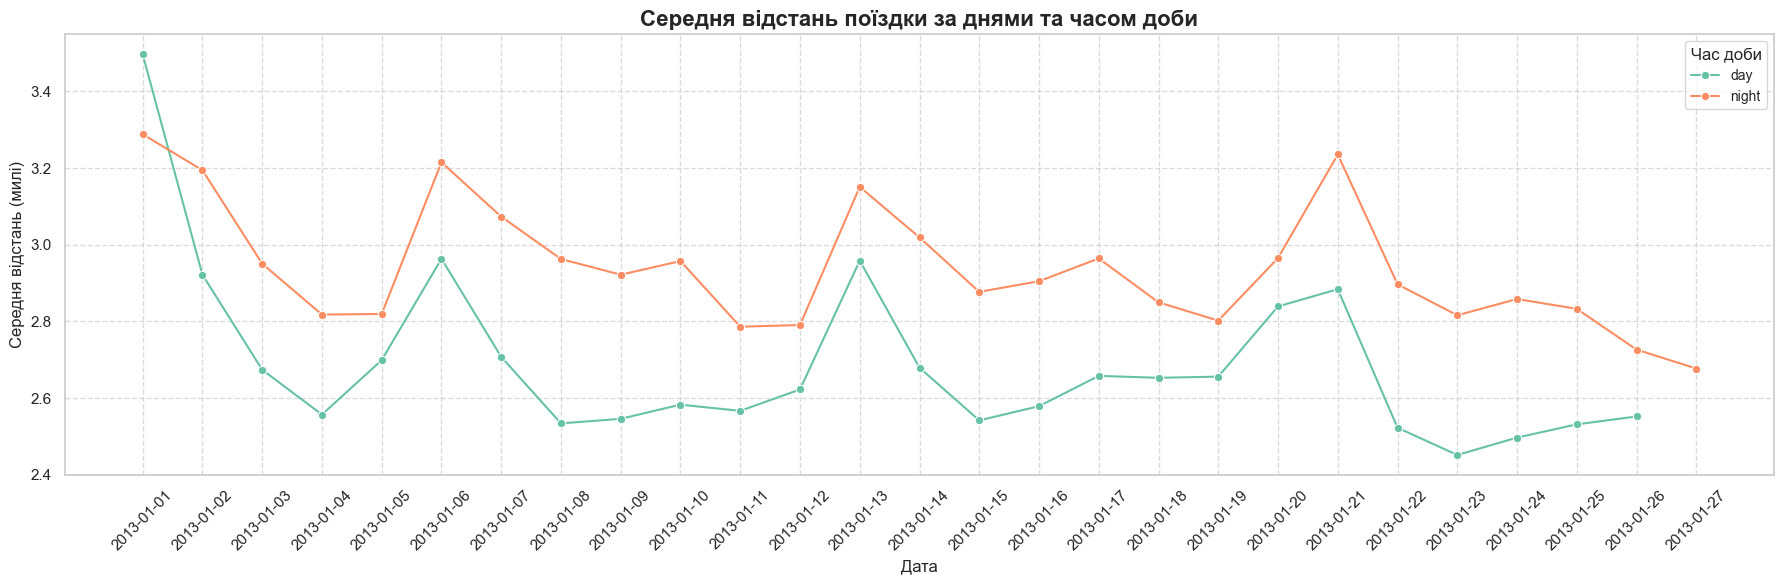

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="Set2")

plt.figure(figsize=(18, 6))
sns.lineplot(
    data=daily_avg_pd,
    x="date",
    y="avg_distance",
    hue="time_of_day",
    marker="o",
    linewidth=1.5
)

plt.title("Середня відстань поїздки за днями та часом доби", fontsize=16, weight='bold')
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Середня відстань (милі)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(title="Час доби", title_fontsize=12, fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
daily_avg.coalesce(1).write.mode("overwrite").csv("/Users/mac/Development/nyc-taxi-spark-project/results/4.csv")